In [27]:
# def __init__(self, N, D, begin, end, noise_std=0.05):

from bdl import SineWithNoiseDataset2
import math

D = 1
N = 1000
train_begin_radians = -2 * math.pi
train_end_radians = 2 * math.pi
test_begin_radians = -4 * math.pi
test_end_radians = 4 * math.pi
dataset = SineWithNoiseDataset2(N, D, train_begin_radians, train_end_radians)
oos_dataset = SineWithNoiseDataset2( N, D, test_begin_radians, test_end_radians)

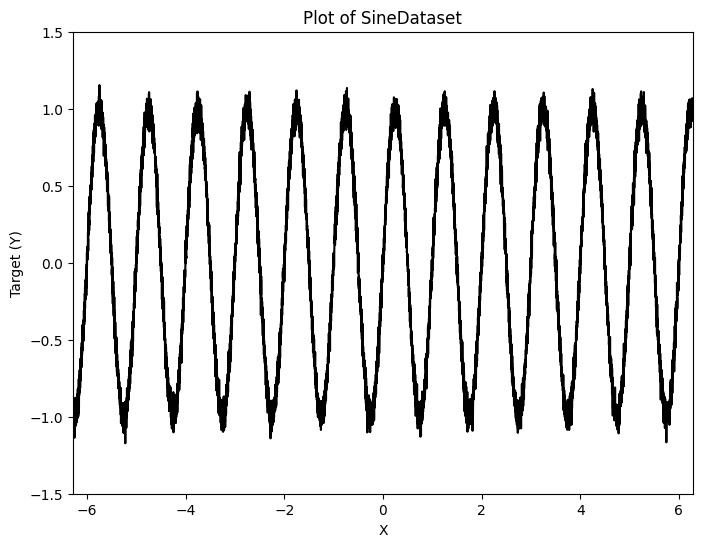

In [28]:
import matplotlib.pyplot as plt
# Extract the data
xs = dataset.xs
ys = dataset.ys
oos_xs = oos_dataset.xs
oos_ys = oos_dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c ="black")
plt.title('Plot of SineDataset')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

In [29]:
from bdl import MiniNN
from bdl import BiggerNN

In [30]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

def train_ensemble(dataloader, model_class, n, input_dim, output_dim, hidden_dim, num_ensembles, cache_size=4):
    epochs = 100
    num_devices = 1

    return push.bayes.ensemble.train_deep_ensemble(
        dataloader,
        torch.nn.MSELoss(),
        epochs,
        model_class, n, input_dim, output_dim, hidden_dim,
        num_devices=num_devices,
        num_ensembles=num_ensembles,
        cache_size=cache_size
    )
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
input_dim = 1
output_dim = 1
hidden_dim = 128
n = 10

two_particle_params = train_ensemble(dataloader, BiggerNN, n, input_dim, output_dim, hidden_dim, num_ensembles=2)
# four_particle_params = train_ensemble(dataloader, BiggerNN, input_dim, output_dim, hidden_dim, num_ensembles=4)
# eight_particle_params = train_ensemble(dataloader, BiggerNN, input_dim, output_dim, hidden_dim, num_ensembles=8)

cache_size:  4


100%|██████████| 100/100 [04:00<00:00,  2.41s/it]


In [23]:
def get_ensemble_models(paramList, num_ensembles, n, input_dim, hidden_dim):
    models = []
    for i in range(num_ensembles):
        model = BiggerNN(n, input_dim, output_dim, hidden_dim)
        
        # Check if the number of parameters in the list matches the number of model parameters
        if len(paramList[i]) != len(list(model.parameters())):
            print("The number of parameters in the list does not match the number of model parameters.")
        else:
            # Iterate through the model parameters and assign values from the list
            for model_param, param_value in zip(model.parameters(), paramList[i]):
                model_param.data = param_value

        models.append(model)
    return models

two_particle_models = get_ensemble_models(two_particle_params, num_ensembles=2, n=4, input_dim=1, hidden_dim=64)
# four_particle_models = get_ensemble_models(four_particle_params, num_ensembles=4, n=4, input_dim=1, hidden_dim=64)
# eight_particle_models = get_ensemble_models(eight_particle_params, num_ensembles=8, n=4, input_dim=1, hidden_dim=64)

The number of parameters in the list does not match the number of model parameters.
The number of parameters in the list does not match the number of model parameters.


In [24]:
import torch

def get_ensemble_output(modelList, dataset, num_ensembles):
    outputs = []
    for i in range(num_ensembles):
        model_i_output = []
        for xs in dataset.xs:
            model_i_output.append(modelList[i](xs).detach())
        outputs.append(model_i_output)
    return outputs

def get_ensemble_average(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the average tensors
    averages = []

    # Calculate the average for each list of tensors and add them to the 'averages' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        average_tensor = torch.mean(stacked_tensor, dim=0)
        averages.append(average_tensor)
    return averages

def get_ensemble_median(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the median tensors
    medians = []

    # Calculate the median for each list of tensors and add them to the 'medians' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        median_tensor = torch.median(stacked_tensor, dim=0).values
        medians.append(median_tensor)
    return medians

def get_ensemble_variance(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the variance tensors
    variances = []

    # Calculate the variance for each list of tensors and add them to the 'variances' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        variance_tensor = torch.var(stacked_tensor, dim=0)
        variances.append(variance_tensor)
    return variances

# Predictions for out of sample
two_model_outputs = get_ensemble_output(two_particle_models, oos_dataset, 2)
# four_model_outputs = get_ensemble_output(four_particle_models, oos_dataset, 4)
# eight_model_outputs = get_ensemble_output(eight_particle_models, oos_dataset, 8)

# Average predictions out of sample
two_model_averages = get_ensemble_average(two_model_outputs)
# four_model_averages = get_ensemble_average(four_model_outputs)
# eight_model_averages = get_ensemble_average(eight_model_outputs)

# Median predictions out of sample
two_model_medians = get_ensemble_median(two_model_outputs)
# four_model_medians = get_ensemble_median(four_model_outputs)
# eight_model_medians = get_ensemble_median(eight_model_outputs)

# Variance
two_model_var = get_ensemble_variance(two_model_outputs)
# four_model_var = get_ensemble_variance(four_model_outputs)
# eight_model_var = get_ensemble_variance(eight_model_outputs)


In [25]:
import numpy as np
# Extract the data
xs = dataset.xs
ys = dataset.ys

# Flatten our x values for out of sample
x_flat = xs.view(-1).numpy()
oos_x_flat = oos_xs.view(-1).numpy()

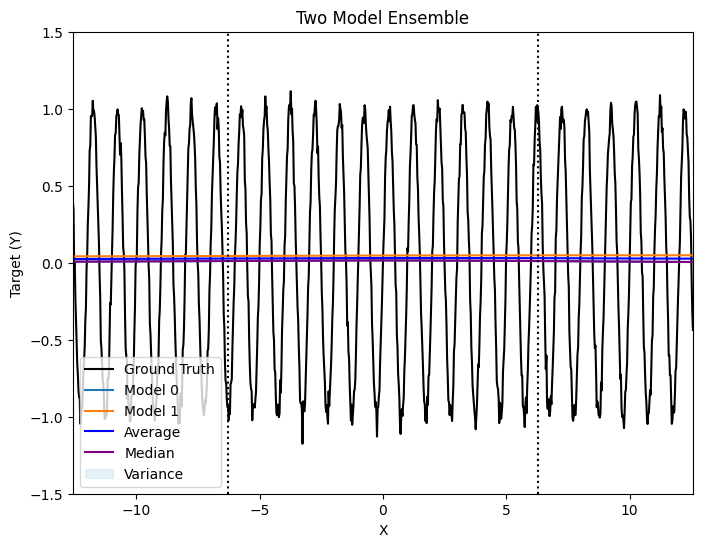

In [26]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, two_model_outputs[0], label="Model 0")
plt.plot(oos_xs, two_model_outputs[1], label="Model 1")

# Plotting Average and Median
plt.plot(oos_xs, two_model_averages, c="blue", label="Average")
plt.plot(oos_xs, two_model_medians, c="purple", label="Median")

# Plotting Bounding Lines for Variance
# Note: You need to adjust the index for two_model_var based on your actual data structure
plt.fill_between(oos_x_flat, torch.tensor(two_model_averages) - torch.tensor(two_model_var), torch.tensor(two_model_averages) + torch.tensor(two_model_var), color='lightblue', alpha=0.3, label='Variance')

plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)

plt.ylim(-1.5, 1.5)
plt.title('Two Model Ensemble')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()